# Bitwise Bakeoff (Random Bake Sets)
-----

This is a logbook outlining our groups efforts and research for the 2nd assignment. To keep the theme on record, it is to create a recipe generator for cookies(desert) using a genetic algorithm approach. We are eager and excited about this and have a couple of ideas we want to test out.

First we trodded off to create a dataset for our genetic algorithm to be based on. There were a lot of resources but we found [this](https://github.com/dpapathanasiou/recipes/blob/master/index/c/cookies.md) To be quite extensive for our use case. We then wrote a simple python script to extract all the data from the links in the page to create a dataset

_Note: The following script is not optimized and is not meant to be used as a library. It is a one time use script to create a dataset for our use case. It takes around 30 minutes to run._



In [3]:
# Program to retrieve all assets from the page as a json dataset
import json
from fractions import Fraction
import re
import requests as req
import os

md_file_url = "https://github.com/dpapathanasiou/recipes/raw/master/index/c/cookies.md"
json_file_url_prefix = "https://github.com/dpapathanasiou/recipes/raw/master/index"
file_name = "./data/recipes.json"

response = req.get(md_file_url)
content = response.text


directory = os.path.dirname(file_name)
if not os.path.exists(directory):
    os.makedirs(directory)


# Extract the url information from the main page
json_urls = []
pattern = r'\]\(([^)]+)\)'
matches = re.findall(pattern, content)
cleaned_links = [match.replace("../../index/", "") for match in matches]
for clean_link in cleaned_links:
    json_url = f"{json_file_url_prefix}/{clean_link}"
    json_urls.append(json_url)

def parse_mixed_fraction(mixed_fraction):
    if ' ' in mixed_fraction:
        # print(mixed_fraction)
        whole_part, fraction_part = mixed_fraction.split(' ')
        fraction = Fraction(fraction_part)
        return str(int(whole_part) + fraction)
    else:
        return mixed_fraction

recipes_data = {
    "recipes":[]
}

for url in json_urls:
  final_ingrs = []
  # get recipe from url
  res = req.get(url)
  data = res.json()

  # get name and ingridients from json
  name = data["title"]
  ingr = data["ingredients"]

  # Reformat the ingridients to required format
  for ing in ingr:
    # pattern = r'^([\d/]+)\s*([a-zA-Z]+)\s*(?:\([^)]+\))?\s*([^,]*)'
    pattern = r'^([\d\s/]+)\s*([a-zA-Z]+)\s*(?:\([^)]+\))?\s*([^,]*)'
    match = re.match(pattern, ing)

    if match:
        new_ingr = {
            "amount": parse_mixed_fraction(match.group(1).strip()),
            "unit": match.group(2),
            "ingridient":match.group(3).strip()
        }
        final_ingrs.append(new_ingr)

  recipe = {
      "title":name,
      "ingridients":final_ingrs
  }
  recipes_data["recipes"].append(recipe)

with open(file_name, "w") as outfile:
    json.dump(recipes_data, outfile, indent=2)
print("Dataset created successfully")

Dataset created successfully


Now that we have a dataset, we explored genetic algorithms and how they work. Seems pretty straight forward, However, most examples tend to become really technicle and focus on solving problems in a binary manner. We decided to try a method where we embrace this binary manner and try to encode each ingridient of a recipe as a bit string, giving values to each ingridient on random. The way evaluation, mutation, and crossover will work are:
### Evaluation
The fitness of the recipe is evaluated on the length of its ingridients. More then length, higher the fitness. We decided for a 40% exploitation i.e 40% of the selected population based on fitness alone, and 60% exploration i.e adding random samples to the selected population. `<write more here>`

### Crossover
Here we have 2 steps
- Assign a random binary notation to the ingridients of 2 randomnly chosen recipes from the population.
- We then take all the ingridients which are encoded as '1' for each recipe and add them into the new recipe

### Mutation
For this task, we chose to have 3 situations randomly chosen to occur. The first common step is to assign a binary encoding to the new recipe
- Chose a ingridient encoded as '0' at random and delete it
- Choose an ingridient encoded as '0' at random, and change the amount with an ingridient encoded as '1' at random
- Choose an ingridient encoded as '1' at random, and double the amount in it.

At the end of this, we select half of the original population at random and half of the selected altered populatoin at random and perform this untill we converge at 4 recipes.

We feel through this, we allow recipes with larger ingridients to express participation but not run the selection. Our aim is to create funky recipes and a creative way is to let allow the algorithm to chaotically pick between all available options.


In [23]:
!pip install namesgenerator

  Preparing metadata (setup.py) ... done
  Created wheel for namesgenerator: filename=namesgenerator-0.3-py3-none-any.whl size=22340 sha256=1b7f340aa7656a2446e49a2c0261978042c0f9a1b0861d04b7be450cf62fe9ed
  Stored in directory: /Users/pradeep/Library/Caches/pip/wheels/80/2e/c0/e262c56ccbabc3c3b989410308bba42dc2b800d3394a2c8fd4
Successfully built namesgenerator


 The best solution found:
 [0.00587825 0.00251231 0.00141611]

 Objective function:
 0.009806677007612175


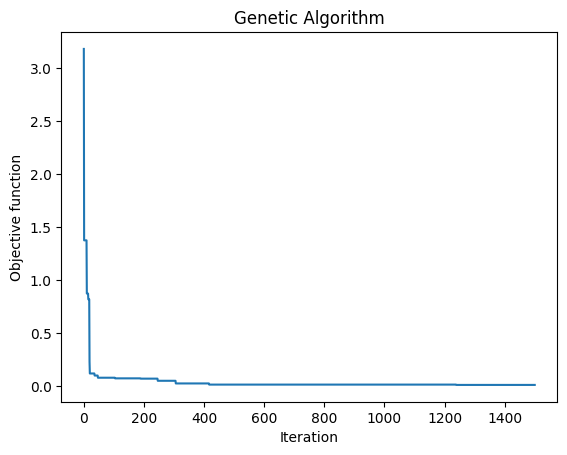

In [5]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def func(x):
  return np.sum(x)

varbound = np.array([[0,10]]*3)

model = ga(function=func,dimension=3,variable_type='real',variable_boundaries=varbound)

model.run()


In [16]:
import os
import numpy as np
import random
import namesgenerator
import json
from fractions import Fraction

dataset_file = "./data/recipes.json"
generation_setter = 0.6
exploration_setter = 0.6
exploitation_setter = 0.4
mutation_rate = 0.2

if not os.path.exists(dataset_file):
    print("Dataset file not found")
    exit()

with open(dataset_file) as json_file:
    data = json.load(json_file)

recipes = data["recipes"]
# Remove recipes with no ingridients
for recipe in recipes:
    if len(recipe["ingridients"]) == 0:
        recipes.remove(recipe)

def mutation_delete_ingridient(recipe):
    # Select a random ingridient from the recipe
    if len(recipe["ingridients"]) == 0:
        return None
    random_ingridient = random.choice(recipe["ingridients"])
    # Delete the ingridient from the recipe
    recipe["ingridients"].remove(random_ingridient)
    return recipe

def mutation_double_amount(recipe):
    # Select a random ingridient from the recipe
    if len(recipe["ingridients"]) == 0:
        return None
    random_ingridient = random.choice(recipe["ingridients"])
    # Check if the "amount" attribute is present
    if "amount" in random_ingridient:
        try:
            # Attempt to parse the "amount" as a fraction
            amount_fraction = Fraction(random_ingridient["amount"])

            # Double the amount as a fraction
            new_amount_fraction = amount_fraction * 2

            # Update the "amount" attribute
            random_ingridient["amount"] = str(new_amount_fraction)
        except ValueError:
            # Handle the case where the "amount" cannot be parsed as a fraction
            print(f"Warning: Unable to parse '{random_ingridient['amount']}' as a fraction.")

    return recipe

def mutation_change_amount(recipe):
    # Select a random ingridient from the recipe
    if len(recipe["ingridients"]) == 0:
        return None
    random_ingridient = random.choice(recipe["ingridients"])
    # Change the amount of the ingridient to one of a random ingriedient from the ingridient list
    random_ingridient["amount"] = random.choice(random.choice(recipes)["ingridients"])["amount"]

    return recipe

def mutation_add_ingridient(recipe):
    # Select a random ingridient from the dataset
    random_recipe = random.choice(recipes)
    random_recipe_ingridient = random.choice(random_recipe["ingridients"])
    # add random ingridient to the recipe
    recipe["ingridients"].append(random_recipe_ingridient)
    return recipe


def mutation(recipe):
    probabilities = [0.2,0.3,0.3,0.2]
    probabilities = [p / sum(probabilities) for p in probabilities]
    selected_mutation = random.choices([mutation_delete_ingridient, mutation_double_amount, mutation_change_amount,mutation_add_ingridient], weights=probabilities)[0]
    return selected_mutation(recipe)

def crossover(recipes):
    new_recipes = {
        "title": namesgenerator.get_random_name() + " Cookies",
        "ingridients": []
    }
    # Select two random recipes
    recipe1 = random.choice(recipes)
    recipe2 = random.choice(recipes)
    while recipe1["title"] == recipe2["title"]:
        recipe2 = random.choice(recipes)

    # 1. Select the ingridients from the recipe
    recipe1_ingridients = recipe1["ingridients"]
    recipe2_ingridients = recipe2["ingridients"]

    # 2. Create a binary encoding scheme for the ingridients
    recipe1_ingridients_binary = []
    recipe2_ingridients_binary = []
    for ingridient in recipe1_ingridients:
        recipe1_ingridients_binary.append(random.randint(0, 1))
    for ingridient in recipe2_ingridients:
        recipe2_ingridients_binary.append(random.randint(0, 1))
    
    # Add ingridients marked as 1 from both recipes to the new recipe in  "ingredients" key
    for i in range(len(recipe1_ingridients_binary)):
        if recipe1_ingridients_binary[i] == 1:
            new_recipes["ingridients"].append(recipe1_ingridients[i])
    for i in range(len(recipe2_ingridients_binary)):
        if recipe2_ingridients_binary[i] == 1:
            new_recipes["ingridients"].append(recipe2_ingridients[i])
    if(new_recipes["ingridients"] == []):
        return recipes
    
    recipes.append(new_recipes)

    return recipes


def get_ingridient_list(recipes):
    ingredients = []
    unique_ingredients = set()
    i = 1
    for recipe in recipes:
        for ingredient in recipe["ingridients"]:
            if ingredient["ingridient"] not in unique_ingredients:
                unique_ingredients.add(ingredient["ingridient"])
                ingredients.append({"id": i, "ingridient": ingredient["ingridient"]})
                i += 1
    return ingredients


def get_fitness(recipe):
    if "ingridients" in recipe:
        return len(recipe["ingridients"])
    else:
        return recipe["fitness"]

def get_sorted_fitness(recipes):
    fitnesses = []
    for recipe in recipes:
        # fitness = {
        #     "title": recipe["title"],
        #     "fitness": get_fitness(recipe)
        # }
        recipe["fitness"] = get_fitness(recipe)
    return sorted(recipes, key=lambda x: x["fitness"])

def select_population(recipes):
    selected_recipes = []
    sorted_fitnesses = get_sorted_fitness(recipes)
    fitness_midpoint = len(sorted_fitnesses) // 2
    # encoding_upper, encoding_lower = get_encoding_boundaries(len(sorted_fitnesses), fitness_midpoint)

    # Create a function to find 60% of total recipes length, then select 40% of that from upper half and 60% from lower half
    total_length = generation_setter * len(sorted_fitnesses)
    upper_length = exploitation_setter * total_length
    lower_length = exploration_setter * total_length

    # Select 40% of recipes from upper half
    for i in range(int(upper_length)):
        if get_fitness(sorted_fitnesses[i]) != 0:
            selected_recipes.append(sorted_fitnesses[i])

    # Select 60% of recipes from lower half randomly
    for i in range(int(lower_length)):
        recipe = sorted_fitnesses[random.randint(fitness_midpoint, len(sorted_fitnesses) - 1)]
        if get_fitness(sorted_fitnesses[random.randint(fitness_midpoint, len(sorted_fitnesses) - 1)]) != 0:
            selected_recipes.append(recipe)

    return selected_recipes

def generate_random_recipes(recipes):
    new_recipes = []
    sel_rec = recipes
    while len(sel_rec) > 6:
        # Selection
        sel_rec = select_population(sel_rec)

        # Crossover
        new_recipes = crossover(sel_rec)

        # Mutation based on a random probability
        for recipe in new_recipes:
            if random.random() < mutation_rate:
                temp = recipe
                recipe = mutation(recipe)
                if recipe == None:
                    new_recipes.remove(temp)

        sel_rec = new_recipes
    
    print(sel_rec)

if __name__ == "__main__":
    # ingridients = get_ingridient_list(recipes)


    generate_random_recipes(recipes)

[{'title': 'Block Party Fruit Cookies', 'ingridients': [{'amount': '1', 'unit': 'sugar', 'ingridient': 'cookies'}], 'fitness': 1}, {'title': 'lucid_shannon Cookies', 'ingridients': [{'amount': '3/2', 'unit': 'cups', 'ingridient': 'packed brown sugar'}, {'amount': '3/4', 'unit': 'cup', 'ingridient': 'white sugar'}, {'amount': '3', 'unit': 'eggs', 'ingridient': ''}, {'amount': '2', 'unit': 'teaspoons', 'ingridient': 'baking powder'}, {'amount': '1', 'unit': 'cup', 'ingridient': 'chopped walnuts'}, {'amount': '2', 'unit': 'cups', 'ingridient': 'semisweet chocolate chips'}, {'amount': '1', 'unit': 'cup', 'ingridient': 'chopped walnuts'}, {'amount': '1/2', 'unit': 'cup', 'ingridient': 'Crisco® Baking Sticks All-Vegetable Shortening'}, {'amount': '3/4', 'unit': 'cup', 'ingridient': 'all-purpose flour'}, {'amount': '2', 'unit': 'teaspoon', 'ingridient': 'kosher salt'}, {'amount': '1', 'unit': 'tablespoons', 'ingridient': 'granulated sugar'}, {'amount': '6', 'unit': 'tablespoons', 'ingridient'